In [1]:
import numpy as np
import h5py
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import time
from math import fabs, sqrt, log, exp

In [2]:
def bound(N, loss, L):
    '''
    Calculate annoying parameters to estimate rho
    '''

    R1 = 0.0
    R2 = 0.0
    Sp1 = 0.0
    Sm1 = 0.0
    Sp2 = 0.0
    Sm2 = 0.0
    for i in range(N + 1):
        # compute plus
        alpha0 = L ** i
        alpha1 = i * L ** (i - 1)
        alpha2 = i * (i - 1) * L ** (i - 2)
        R1 += alpha0
        Sp1 += alpha1
        Sp2 += alpha2
        # compute minus
        beta0 = 0.0
        beta1 = 0.0
        beta2 = 0.0
        for k in range(i, N + 1):
            # compute forward difference
            delta = 0.0
            for j in range(k + 1):
                delta += comb_dict[k][j] * (-1) ** (k - j) * loss(j / N)
            # compute coefficient
            beta0 += comb_dict[N][k] * comb_dict[k][i] * (N + 1) * fabs(delta) / (2 ** k) / (L ** i)
            beta1 += comb_dict[N][k] * comb_dict[k][i] * (N + 1) * (k - i) * fabs(delta) / (2 ** k) / (L ** (i + 1))
            beta2 += comb_dict[N][k] * comb_dict[k][i] * (N + 1) * (k - i) * (k - i - 1) * fabs(delta) / (2 ** k) / (
                        L ** (i + 2))
        R2 += beta0
        Sm1 += beta1
        Sm2 += beta2

    gamma = max((2 * R1 + R2) * Sp2 + Sp1 ** 2, (2 * R2 + R1) * Sm2 + Sm1 ** 2) / (N + 1)

    return R1, R2, gamma

In [3]:
def bern_loss_func(name, L):
    
    '''
    Define loss function

    input:
        name - name of loss funtion
        L - bound for prod

    output:
        loss - loss function
    '''
    
    if name == 'hinge':
        loss = lambda x: max(0, 1 + L - 2 * L * x)
    elif name == 'logistic':
        loss = lambda x: log(1 + exp(L - 2 * L * x))
    else:
        print('Wrong loss function!')

    return loss

In [4]:
def pos(i,prod,L):
    '''
    Compute positive function and gradient information
    
    input:
        i - index of function
        t - iteration
        prod - wt*xt
        
    output:
        fpt - positive function value
        gfpt - positive function gradient
        wasted - time wasted on computing
    '''
    
    start = time.time()
    
    plus = L/2+prod
    fpt = plus**i
    gfpt = fpt*i/plus # no xt yet!
    
    wasted = time.time() - start
    
    return fpt,gfpt,wasted              

In [5]:
def comb(n, k):
    '''
    Compute combination
    
    input:
        n - total number
        k - number of chosen
    
    output:
        c - number of combination
    '''
    return factorial(n) / factorial(k) / factorial(n - k)

In [6]:
comb_dict = {0:{0:1},1:{0:1,1:1},2:{0:1,1:2,2:1},3:{0:1,1:3,2:3,3:1},4:{0:1,1:4,2:6,3:4,4:1},
             5:{0:1,1:5,2:10,3:10,4:5,5:1},6:{0:1,1:6,2:15,3:20,4:15,5:6,6:1},
             7:{0:1,1:7,2:21,3:35,4:35,5:21,6:7,7:1},8:{0:1,1:8,2:28,3:56,4:70,5:56,6:28,7:8,8:1},
             9:{0:1,1:9,2:36,3:84,4:126,5:126,6:84,7:36,8:9,9:1},
             10:{0:1,1:10,2:45,3:120,4:210,5:252,6:210,7:120,8:45,9:10,10:1}}

In [7]:
def neg(N,loss,i,prod,L):
    '''
    Compute negative function and gradient information
    
    input:
        loss - loss function
        i - index of function
        t - iteration
        prod - wt*xt
        
    output:
        fnt - negative function value
        gfnt - negative function gradient
        wasted - time wasted on computing
    '''
    
    start = time.time()
    
    minus = L/2-prod
    fnt = 0.0
    gfnt = 0.0
    for k in range(i,N+1):
        # compute forward difference
        delta = 0.0
        for j in range(k+1):
            delta += comb_dict[k][j]*(-1)**(k-j)*loss(j/N)
            
        # compute coefficient
        beta = (comb_dict[N][k]*comb_dict[k][i]*(N+1)*delta/((2*L)**k))*(minus**(k-i))
        # compute function value
        fnt += beta
        # compute gradient
        gfnt += beta*(k-i)/minus  # no xt yet!
    
    wasted = time.time() - start
    return fnt,gfnt,wasted

In [8]:
def w_grad(gfpt,gfnt,yt,at,bt,alphat):
    '''
    Gradient with respect to w
    
    input:
        fpt - positive function at t
        gfpt - positive function gradient at t
        fnt - negative function at t
        gfnt - negative function gradient at t
        yt - sample label at t
        pt - p at t
        at - a at t
        bt - b at t
        alphat - alpha at t
    output:
        gradwt - gradient w.r.t. w at t
    '''
    if yt == 1:
        gradwt = 2*(alphat - at)*gfpt
    else:
        gradwt = 2*(alphat - bt)*gfnt
    return gradwt

In [9]:
def proj(x,R):
    '''
    Projection
    
    input:
        x - 
        R - radius
        
    output:
        proj - projected 
    '''
    norm = np.linalg.norm(x)
    if norm > R:
        x = x/norm*R
    return x

In [10]:
def a_grad(fpt,yt,at):
    '''
    Gradient with respect to a
    
    input:
        fpt - positive function at t
        yt - sample label at t
        pt - p at t
        at - a at t
    
    output:
        gradat - gradient w.r.t a at t
    '''
    gradat = 0.0 
    if yt == 1:
        gradat = 2*(at - fpt)
    else:
        gradat = 2*at
    return gradat

In [11]:
def b_grad(fnt,yt,bt):
    '''
    Gradient with respect to b
    
    input:
        fnt - negative function at t
        yt - sample label at t
        pt - p at t
        bt - b at t
    
    output:
        gradbt - gradient w.r.t b at t
    '''
    gradbt = 0.0 
    if yt == 1:
        gradbt = 2*bt
    else:
        gradbt = 2*(bt - fnt)
    return gradbt

In [12]:
def alpha_grad(fpt,fnt,yt,alphat):
    '''
    Gradient with respect to alpha
    '''
    gradalphat = 0.0
    if yt == 1:
        gradalphat = -2*(alphat - fpt)
    else:
        gradalphat = -2*(alphat - fnt)
    return gradalphat

In [13]:
def prox(N, eta, loss, index, X, Y, L, R1, R2, gamma, wj, aj, bj, alphaj, bwt):
    '''
    perform proximal guided gradient descent when receive an sample

    input:
        N - 
        eta - step size
        loss - loss function
        index -
        X - sample features
        Y - sample labels
        L -
        R1 -
        R2 -
        gamma -
        wj -
        aj -
        bj -
        alphaj -
        bwt -

    output:
        wj - w at jth step
        aj -
        bj -
        alphaj -
        wasted - time wasted on computing
    '''

    prod = np.dot(wj, X[index])
    wasted = 0.0
    fpt = np.zeros(N + 1)
    gfpt = np.zeros(N + 1)
    fnt = np.zeros(N + 1)
    gfnt = np.zeros(N + 1)
    gradwt = 0.0
    
    for i in range(N + 1):
        fpt[i], gfpt[i], _ = pos(i, prod, L)
        wasted += _
        fnt[i], gfnt[i], _ = neg(N, loss, i, prod, L)
        wasted += _
        gradwt += w_grad(gfpt[i], gfnt[i], Y[index], aj[i], bj[i], alphaj[i])  # accumulate i
        gradat = a_grad(fpt[i], Y[index], aj[i])
        gradbt = b_grad(fnt[i], Y[index], bj[i])
        gradalphat = alpha_grad(fpt[i], fnt[i], Y[index], alphaj[i])

        aj[i] = aj[i] - eta * gradat / (2 * (N + 1))
        bj[i] = bj[i] - eta * gradbt / (2 * (N + 1))
        alphaj[i] = alphaj[i] + eta * gradalphat / (2 * (N + 1))

    wj = wj - eta * (gradwt * X[index] * Y[index] / (2 * (N + 1)) + gamma * (wj - bwt))

    wj = proj(wj, L / 2)
    aj = proj(aj, R1)
    bj = proj(bj, R2)
    alphaj = proj(alphaj, R1 + R2)

    return wj, aj, bj, alphaj, wasted

In [34]:
def PGSPD(N, t, loss, passing_list, X, Y, L, R1, R2, gamma, c, bwt, bat, bbt, balphat):

    '''
    Proximally Guided Stochastic Primal Dual Inner loop

    input:
        N - 
        t - iteration at t
        loss - loss function
        passing_list
        X -
        Y -
        L -
        R1 -
        R2 -
        gamma -
        c -
        bwt - last outer loop w
        bat - last outer loop a
        bbt - last outer loop b
        balphat - last outer loop alpha

    output:
        bwt - next outer loop w
        bat - next outer loop a
        bbt - next outer loop b
        balphat - next outer loop alpha
        wasted - time wasted on computing
    '''
    
    wasted = 0.0
    # initialize inner loop variables
    Wt = bwt + 0.0
    At = bat + 0.0
    Bt = bbt + 0.0
    ALPHAt = balphat + 0.0

    BWt = 0.0
    BAt = 0.0
    BBt = 0.0
    BALPHAt = 0.0

    ETAt = c / sqrt(t) / gamma
    
    t0 = min(t,100)

    # inner loop update at j
    for j in range(t0):
        # update inner loop variables
        Wt, At, Bt, ALPHAt, _ = prox(N, ETAt, loss, passing_list[j], X, Y, L, R1, R2, gamma, Wt, At, Bt, ALPHAt, bwt)
        wasted += _
        
        BWt += Wt
        BAt += At
        BBt += Bt
        BALPHAt += ALPHAt

    # update outer loop variables
    bwt = BWt / t0
    bat = BAt / t0
    bbt = BBt / t0
    balphat = BALPHAt / t0

    return bwt, bat, bbt, balphat, wasted

In [15]:
def SAUC(T,name,N,L,c,Xtr,Ytr,Xte,Yte,stamp = 10):
    '''
    Stochastic AUC Optimization with General Loss

    input:
        T -
        name -
        N - Bernstein degree
        L - Bound for prod
        c - step size parameter
        Xtr - Training features
        Ytr - Training labels
        Xte - Testing features
        Yte - Testing labels
        stamp - record stamp

    output:
        elapsed_time -
        roc_auc - auc scores
    '''
    
    sum_time = 0.0
    
    wasted = 0.0 
    
    print('SAUC......')
    
    # get the dimension of what we are working with
    n, d = Xtr.shape

    WT = np.zeros(d)
    AT = np.zeros(N + 1)
    BT = np.zeros(N + 1)
    ALPHAT = np.zeros(N + 1)

    # define loss function
    loss = bern_loss_func(name, L)

    # compute gamma(get it done, bitch!)
    R1, R2, gamma = bound(N,loss,L)

    # record auc
    roc_auc = []

    # record time elapsed
    elapsed_time = []
    start_time = time.time()

    # Begin algorithm
    for t in range(1, T + 1):

        # Prepare the indices if you know what I mean
        prep_time = time.time()
        epoch = t // n
        begin = (t * (t - 1) // 2) % n
        end = (t * (t + 1) // 2) % n
        if epoch < 1:
            if begin < end:
                tr_list = [i for i in range(begin, end)]
            else:  # need to think better
                tr_list = [i for i in range(begin, n)] + [i for i in range(end)]
        else:
            if begin < end:
                tr_list = [i for i in range(begin, n)] + [i for i in range(n)] * (epoch - 1) + [i for i in range(end)]
            else:
                tr_list = [i for i in range(begin, n)] + [i for i in range(n)] * epoch + [i for i in range(end)]
        sum_time += time.time() - prep_time
        # Inner loop
        WT, AT, BT, ALPHAT, _ = PGSPD(N, t, loss, tr_list, Xtr, Ytr, L, R1, R2, gamma, c, WT, AT, BT, ALPHAT)
        wasted += _
        if t % stamp == 0:
            elapsed_time.append(time.time() - start_time - sum_time - wasted)
            roc_auc.append(roc_auc_score(Yte, np.dot(Xte, WT)))
            print('gamma: %.2f c: %.2f iteration: %d AUC: %.6f time eplapsed: %.2f/%.2f' % (gamma, c, t, roc_auc[-1], elapsed_time[-1],wasted))

            sum_time = 0.0
            # start_time = time.time()

    return elapsed_time, roc_auc

In [16]:
def loss_func(name):
    '''
    Define loss function

    input:
        name - name of loss function

    output:
        loss - loss function
    '''

    if name == 'hinge':
        loss = lambda x: max(0, 1 - x)
    elif name == 'logistic':
        loss = lambda x: log(1 + exp(-x))
    else:
        print('Wrong loss function!')

    return loss

In [17]:
def reservior(Bt,xt,N,M):
    '''
    Reservior Sampling

    input:
        Bt - current buffer
        xt - a training instance
        N - the buffer size
        M - the number of instances received till trial t

    output:
        Bt - updated buffer
    '''

    L = len(Bt)
    if L < N:
        Bt.append(xt)
    else:
        z = np.random.binomial(1, p=N/M)
        if z == 1:
            ind = np.random.randint(L)
            Bt[ind] = xt

    return Bt

In [18]:
def seq(loss,wt,xt,yt,B,ct):
    '''
    Sequential update

    input:
        grad - gradient of loss function
        wt - the current classifier
        xt -
        yt -
        B - the buffer to be compared to
        ct - a parameter that weights the comparison

    output:
        wt - th updated classifier
    '''
    L = len(B)
    for i in range(L):
        prod = np.inner(wt,xt - B[i])
        norm = np.inner(xt - B[i],xt - B[i])
        tau = min(ct/2,loss(prod*yt)/norm)
        wt += tau*yt*(xt - B[i])

    return wt

In [19]:
def gra(wt,xt,yt,B,ct):
    '''
    gradient updating

    input:
        wt - the current classifier
        xt -
        yt -
        B - the bufferto be compared to
        ct - a parameter that weights the comparison

    output:
        wt - th updated classifier
    '''
    L = len(B)
    w = wt + 0.0
    for i in range(L):
        prod = np.inner(w,xt - B[i])
        if yt*prod <= 1:
            wt += ct*yt*(xt - B[i])/2

    return wt

In [20]:
def OAM(T,name,option,c,Np,Nn,Xtr,Ytr,Xte,Yte,stamp = 10):
    '''
    Online AUC Maximization

    input:
        T -
        name -
        option - update option
        c - penalty parameter
        Np - maximum buffer size of positive samples
        Nn - maximum buffer size of negative samples
        Xtr -
        Ytr -
        Xte -
        Yte -
        stamp - record stamp

    output:
        elapsed_time -
        roc_auc - auc scores
    '''

    print('OAM......')

    # get the dimension of what we are working with
    n, d = Xtr.shape

    # define loss function
    loss = loss_func(name)

    # initialize
    wt = np.zeros(d)
    Bpt = []
    Bnt = []
    Npt = 0
    Nnt = 0
    # record auc
    roc_auc = []

    # record time elapsed
    elapsed_time = []
    start_time = time.time()

    for t in range(1,T+1):
        if Ytr[t%n] == 1:
            Npt += 1
            ct = c*max(1,Nnt/Nn)
            Bpt = reservior(Bpt,Xtr[t%n],Np,Npt)
            if option == 'sequential':
                wt = seq(loss,wt,Xtr[t%n],Ytr[t%n],Bnt,ct)
            elif option == 'gradient':
                wt = gra(wt, Xtr[t % n], Ytr[t % n], Bnt, ct)
            else:
                print('Wrong update option!')
                return
        else:
            Nnt += 1
            ct = c*max(1,Npt/Np)
            Bnt = reservior(Bnt,Xtr[t%n],Nn,Nnt)
            if option == 'sequential':
                wt = seq(loss,wt,Xtr[t%n],Ytr[t%n],Bpt,ct)
            elif option == 'gradient':
                wt = gra(wt, Xtr[t % n], Ytr[t % n], Bpt, ct)
            else:
                print('Wrong update option!')
                return

        if t % stamp == 0:
            elapsed_time.append(time.time() - start_time)
            roc_auc.append(roc_auc_score(Yte, np.dot(Xte, wt)))
            print('c: %.2f iteration: %d AUC: %.6f time eplapsed: %.2f' % (c, t, roc_auc[-1], elapsed_time[-1]))

            # start_time = time.time()

    return elapsed_time, roc_auc

In [21]:
# Read data from hdf5 file
dataset = 'sector'
hf = h5py.File('/home/neyo/PycharmProjects/AUC/datasets/%s.h5' % (dataset), 'r')
FEATURES = hf['FEATURES'][:]
LABELS = hf['LABELS'][:]
hf.close()

In [41]:
# Define hyper parameters
N = 3
T = 2000
folders = 2
stamp = 10

In [23]:
# Define model parameters
L = [1]
C = [10]
Np = [100]
Nn = [100]

In [24]:
# Define losses and algorithms
NAME = ['hinge','logistic']
ALG = ['SAUC','OAM']
OPTION = ['sequential','gradient']

In [25]:
# Prepare training and testing
n = len(LABELS)
training = [i for i in range(n // 2)]
testing = [i for i in range(n // 2, n)]

In [37]:
res = {}
for name in NAME:
    for alg in ALG:
        if alg == 'SAUC':
            res[(name,alg)] = SAUC(T,name,N,L[0],C[0],FEATURES[training],LABELS[training],FEATURES[testing],LABELS[testing],stamp = stamp)
        else:
            for option in OPTION:
                res[(name,alg+'_'+option)] = OAM(T,name,option,C[0],Np[0],Nn[0],FEATURES[training],LABELS[training],FEATURES[testing],LABELS[testing],stamp = stamp)

SAUC......
gamma: 57.00 c: 10.00 iteration: 10 AUC: 0.485443 time eplapsed: 0.05/0.01
gamma: 57.00 c: 10.00 iteration: 20 AUC: 0.527687 time eplapsed: 0.28/0.02
gamma: 57.00 c: 10.00 iteration: 30 AUC: 0.541256 time eplapsed: 0.56/0.04
gamma: 57.00 c: 10.00 iteration: 40 AUC: 0.561843 time eplapsed: 0.87/0.07
gamma: 57.00 c: 10.00 iteration: 50 AUC: 0.583565 time eplapsed: 1.25/0.11
gamma: 57.00 c: 10.00 iteration: 60 AUC: 0.604434 time eplapsed: 1.71/0.15
gamma: 57.00 c: 10.00 iteration: 70 AUC: 0.625896 time eplapsed: 2.24/0.21
gamma: 57.00 c: 10.00 iteration: 80 AUC: 0.647999 time eplapsed: 2.82/0.27
gamma: 57.00 c: 10.00 iteration: 90 AUC: 0.666172 time eplapsed: 3.48/0.34
gamma: 57.00 c: 10.00 iteration: 100 AUC: 0.683165 time eplapsed: 4.22/0.42
gamma: 57.00 c: 10.00 iteration: 110 AUC: 0.694993 time eplapsed: 4.93/0.50
gamma: 57.00 c: 10.00 iteration: 120 AUC: 0.706801 time eplapsed: 5.84/0.58
gamma: 57.00 c: 10.00 iteration: 130 AUC: 0.718734 time eplapsed: 6.76/0.66
gamma: 57.

gamma: 57.00 c: 10.00 iteration: 1080 AUC: 0.853168 time eplapsed: 87.04/8.72
gamma: 57.00 c: 10.00 iteration: 1090 AUC: 0.852629 time eplapsed: 87.79/8.80
gamma: 57.00 c: 10.00 iteration: 1100 AUC: 0.853093 time eplapsed: 88.60/8.88
gamma: 57.00 c: 10.00 iteration: 1110 AUC: 0.852815 time eplapsed: 89.38/8.97
gamma: 57.00 c: 10.00 iteration: 1120 AUC: 0.852644 time eplapsed: 90.33/9.05
gamma: 57.00 c: 10.00 iteration: 1130 AUC: 0.853054 time eplapsed: 91.26/9.13
gamma: 57.00 c: 10.00 iteration: 1140 AUC: 0.853194 time eplapsed: 92.16/9.21
gamma: 57.00 c: 10.00 iteration: 1150 AUC: 0.853678 time eplapsed: 92.96/9.29
gamma: 57.00 c: 10.00 iteration: 1160 AUC: 0.853487 time eplapsed: 93.78/9.38
gamma: 57.00 c: 10.00 iteration: 1170 AUC: 0.853567 time eplapsed: 94.55/9.45
gamma: 57.00 c: 10.00 iteration: 1180 AUC: 0.854077 time eplapsed: 95.45/9.53
gamma: 57.00 c: 10.00 iteration: 1190 AUC: 0.853885 time eplapsed: 96.39/9.62
gamma: 57.00 c: 10.00 iteration: 1200 AUC: 0.854478 time eplapse

c: 10.00 iteration: 150 AUC: 0.634740 time eplapsed: 3.94
c: 10.00 iteration: 160 AUC: 0.638009 time eplapsed: 4.32
c: 10.00 iteration: 170 AUC: 0.641210 time eplapsed: 4.70
c: 10.00 iteration: 180 AUC: 0.641747 time eplapsed: 5.18
c: 10.00 iteration: 190 AUC: 0.650072 time eplapsed: 5.69
c: 10.00 iteration: 200 AUC: 0.658865 time eplapsed: 6.29
c: 10.00 iteration: 210 AUC: 0.664270 time eplapsed: 7.01
c: 10.00 iteration: 220 AUC: 0.664331 time eplapsed: 7.51
c: 10.00 iteration: 230 AUC: 0.676421 time eplapsed: 8.06
c: 10.00 iteration: 240 AUC: 0.683055 time eplapsed: 8.65
c: 10.00 iteration: 250 AUC: 0.688649 time eplapsed: 9.21
c: 10.00 iteration: 260 AUC: 0.692415 time eplapsed: 9.72
c: 10.00 iteration: 270 AUC: 0.697988 time eplapsed: 10.30
c: 10.00 iteration: 280 AUC: 0.698637 time eplapsed: 10.82
c: 10.00 iteration: 290 AUC: 0.700347 time eplapsed: 11.34
c: 10.00 iteration: 300 AUC: 0.705513 time eplapsed: 12.06
c: 10.00 iteration: 310 AUC: 0.706937 time eplapsed: 12.81
c: 10.00 

c: 10.00 iteration: 1540 AUC: 0.845859 time eplapsed: 85.12
c: 10.00 iteration: 1550 AUC: 0.847571 time eplapsed: 85.61
c: 10.00 iteration: 1560 AUC: 0.847813 time eplapsed: 86.11
c: 10.00 iteration: 1570 AUC: 0.848417 time eplapsed: 86.62
c: 10.00 iteration: 1580 AUC: 0.848551 time eplapsed: 87.11
c: 10.00 iteration: 1590 AUC: 0.849930 time eplapsed: 87.72
c: 10.00 iteration: 1600 AUC: 0.850251 time eplapsed: 88.21
c: 10.00 iteration: 1610 AUC: 0.850332 time eplapsed: 88.70
c: 10.00 iteration: 1620 AUC: 0.850163 time eplapsed: 89.20
c: 10.00 iteration: 1630 AUC: 0.850144 time eplapsed: 89.71
c: 10.00 iteration: 1640 AUC: 0.850347 time eplapsed: 90.21
c: 10.00 iteration: 1650 AUC: 0.851503 time eplapsed: 90.72
c: 10.00 iteration: 1660 AUC: 0.852042 time eplapsed: 91.20
c: 10.00 iteration: 1670 AUC: 0.851696 time eplapsed: 91.69
c: 10.00 iteration: 1680 AUC: 0.851715 time eplapsed: 92.18
c: 10.00 iteration: 1690 AUC: 0.852358 time eplapsed: 92.70
c: 10.00 iteration: 1700 AUC: 0.853026 t

c: 10.00 iteration: 930 AUC: 0.710878 time eplapsed: 16.32
c: 10.00 iteration: 940 AUC: 0.710269 time eplapsed: 16.49
c: 10.00 iteration: 950 AUC: 0.711283 time eplapsed: 16.68
c: 10.00 iteration: 960 AUC: 0.711283 time eplapsed: 16.85
c: 10.00 iteration: 970 AUC: 0.711718 time eplapsed: 17.05
c: 10.00 iteration: 980 AUC: 0.682668 time eplapsed: 17.24
c: 10.00 iteration: 990 AUC: 0.705677 time eplapsed: 17.45
c: 10.00 iteration: 1000 AUC: 0.718283 time eplapsed: 17.62
c: 10.00 iteration: 1010 AUC: 0.723858 time eplapsed: 17.81
c: 10.00 iteration: 1020 AUC: 0.724362 time eplapsed: 17.99
c: 10.00 iteration: 1030 AUC: 0.724362 time eplapsed: 18.18
c: 10.00 iteration: 1040 AUC: 0.725297 time eplapsed: 18.36
c: 10.00 iteration: 1050 AUC: 0.718370 time eplapsed: 18.56
c: 10.00 iteration: 1060 AUC: 0.722262 time eplapsed: 18.75
c: 10.00 iteration: 1070 AUC: 0.725067 time eplapsed: 18.94
c: 10.00 iteration: 1080 AUC: 0.727185 time eplapsed: 19.12
c: 10.00 iteration: 1090 AUC: 0.728343 time epl

gamma: 48.61 c: 10.00 iteration: 240 AUC: 0.736796 time eplapsed: 14.06/1.64
gamma: 48.61 c: 10.00 iteration: 250 AUC: 0.740026 time eplapsed: 14.82/1.73
gamma: 48.61 c: 10.00 iteration: 260 AUC: 0.745650 time eplapsed: 15.75/1.83
gamma: 48.61 c: 10.00 iteration: 270 AUC: 0.748409 time eplapsed: 16.50/1.92
gamma: 48.61 c: 10.00 iteration: 280 AUC: 0.753040 time eplapsed: 17.43/2.01
gamma: 48.61 c: 10.00 iteration: 290 AUC: 0.757048 time eplapsed: 18.15/2.11
gamma: 48.61 c: 10.00 iteration: 300 AUC: 0.758995 time eplapsed: 19.22/2.20
gamma: 48.61 c: 10.00 iteration: 310 AUC: 0.762235 time eplapsed: 20.44/2.30
gamma: 48.61 c: 10.00 iteration: 320 AUC: 0.765141 time eplapsed: 21.42/2.39
gamma: 48.61 c: 10.00 iteration: 330 AUC: 0.767591 time eplapsed: 22.28/2.49
gamma: 48.61 c: 10.00 iteration: 340 AUC: 0.772115 time eplapsed: 23.16/2.58
gamma: 48.61 c: 10.00 iteration: 350 AUC: 0.774524 time eplapsed: 24.13/2.68
gamma: 48.61 c: 10.00 iteration: 360 AUC: 0.777743 time eplapsed: 24.96/2.77

gamma: 48.61 c: 10.00 iteration: 1300 AUC: 0.848274 time eplapsed: 95.60/11.24
gamma: 48.61 c: 10.00 iteration: 1310 AUC: 0.848522 time eplapsed: 96.31/11.32
gamma: 48.61 c: 10.00 iteration: 1320 AUC: 0.848733 time eplapsed: 97.01/11.41
gamma: 48.61 c: 10.00 iteration: 1330 AUC: 0.848734 time eplapsed: 97.73/11.49
gamma: 48.61 c: 10.00 iteration: 1340 AUC: 0.848865 time eplapsed: 98.45/11.58
gamma: 48.61 c: 10.00 iteration: 1350 AUC: 0.848866 time eplapsed: 99.16/11.66
gamma: 48.61 c: 10.00 iteration: 1360 AUC: 0.848652 time eplapsed: 99.91/11.75
gamma: 48.61 c: 10.00 iteration: 1370 AUC: 0.849361 time eplapsed: 100.63/11.83
gamma: 48.61 c: 10.00 iteration: 1380 AUC: 0.849910 time eplapsed: 101.33/11.92
gamma: 48.61 c: 10.00 iteration: 1390 AUC: 0.850430 time eplapsed: 102.01/12.00
gamma: 48.61 c: 10.00 iteration: 1400 AUC: 0.850188 time eplapsed: 102.71/12.08
gamma: 48.61 c: 10.00 iteration: 1410 AUC: 0.849911 time eplapsed: 103.43/12.17
gamma: 48.61 c: 10.00 iteration: 1420 AUC: 0.85

c: 10.00 iteration: 450 AUC: 0.731579 time eplapsed: 23.00
c: 10.00 iteration: 460 AUC: 0.732371 time eplapsed: 23.68
c: 10.00 iteration: 470 AUC: 0.732704 time eplapsed: 24.47
c: 10.00 iteration: 480 AUC: 0.732586 time eplapsed: 25.03
c: 10.00 iteration: 490 AUC: 0.734903 time eplapsed: 25.58
c: 10.00 iteration: 500 AUC: 0.737464 time eplapsed: 26.09
c: 10.00 iteration: 510 AUC: 0.741897 time eplapsed: 26.76
c: 10.00 iteration: 520 AUC: 0.744504 time eplapsed: 27.42
c: 10.00 iteration: 530 AUC: 0.746839 time eplapsed: 27.94
c: 10.00 iteration: 540 AUC: 0.748088 time eplapsed: 28.46
c: 10.00 iteration: 550 AUC: 0.750980 time eplapsed: 29.01
c: 10.00 iteration: 560 AUC: 0.754807 time eplapsed: 29.76
c: 10.00 iteration: 570 AUC: 0.752270 time eplapsed: 30.45
c: 10.00 iteration: 580 AUC: 0.751429 time eplapsed: 31.01
c: 10.00 iteration: 590 AUC: 0.758375 time eplapsed: 31.57
c: 10.00 iteration: 600 AUC: 0.759721 time eplapsed: 32.11
c: 10.00 iteration: 610 AUC: 0.759200 time eplapsed: 32.

c: 10.00 iteration: 1830 AUC: 0.851089 time eplapsed: 108.65
c: 10.00 iteration: 1840 AUC: 0.851418 time eplapsed: 109.20
c: 10.00 iteration: 1850 AUC: 0.850825 time eplapsed: 109.90
c: 10.00 iteration: 1860 AUC: 0.849687 time eplapsed: 110.73
c: 10.00 iteration: 1870 AUC: 0.849195 time eplapsed: 111.57
c: 10.00 iteration: 1880 AUC: 0.852044 time eplapsed: 112.18
c: 10.00 iteration: 1890 AUC: 0.852726 time eplapsed: 112.81
c: 10.00 iteration: 1900 AUC: 0.853291 time eplapsed: 113.31
c: 10.00 iteration: 1910 AUC: 0.853539 time eplapsed: 113.96
c: 10.00 iteration: 1920 AUC: 0.854141 time eplapsed: 114.76
c: 10.00 iteration: 1930 AUC: 0.855574 time eplapsed: 115.39
c: 10.00 iteration: 1940 AUC: 0.854898 time eplapsed: 116.02
c: 10.00 iteration: 1950 AUC: 0.854644 time eplapsed: 116.58
c: 10.00 iteration: 1960 AUC: 0.854883 time eplapsed: 117.08
c: 10.00 iteration: 1970 AUC: 0.855093 time eplapsed: 117.75
c: 10.00 iteration: 1980 AUC: 0.855409 time eplapsed: 118.40
c: 10.00 iteration: 1990

c: 10.00 iteration: 1220 AUC: 0.729031 time eplapsed: 25.66
c: 10.00 iteration: 1230 AUC: 0.726735 time eplapsed: 25.98
c: 10.00 iteration: 1240 AUC: 0.728547 time eplapsed: 26.22
c: 10.00 iteration: 1250 AUC: 0.729180 time eplapsed: 26.42
c: 10.00 iteration: 1260 AUC: 0.731815 time eplapsed: 26.60
c: 10.00 iteration: 1270 AUC: 0.732000 time eplapsed: 26.77
c: 10.00 iteration: 1280 AUC: 0.732000 time eplapsed: 27.06
c: 10.00 iteration: 1290 AUC: 0.737490 time eplapsed: 27.31
c: 10.00 iteration: 1300 AUC: 0.744618 time eplapsed: 27.56
c: 10.00 iteration: 1310 AUC: 0.744618 time eplapsed: 27.96
c: 10.00 iteration: 1320 AUC: 0.745249 time eplapsed: 28.15
c: 10.00 iteration: 1330 AUC: 0.750803 time eplapsed: 28.35
c: 10.00 iteration: 1340 AUC: 0.754187 time eplapsed: 28.57
c: 10.00 iteration: 1350 AUC: 0.754187 time eplapsed: 28.76
c: 10.00 iteration: 1360 AUC: 0.754187 time eplapsed: 28.97
c: 10.00 iteration: 1370 AUC: 0.754187 time eplapsed: 29.17
c: 10.00 iteration: 1380 AUC: 0.753468 t

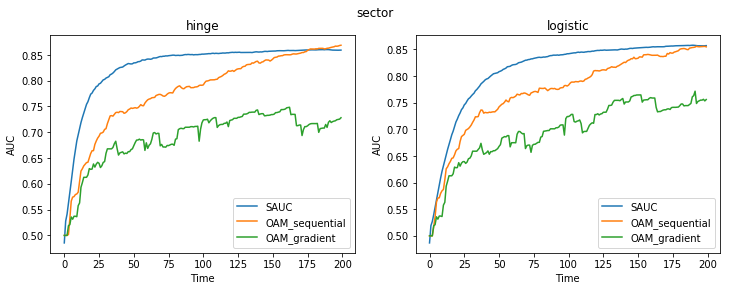

In [40]:
# Plot results
fig = plt.figure(figsize=(12, 4)) # create a figure object
fig.suptitle(dataset)

for name in NAME:
    for alg in ALG:
        ax = fig.add_subplot(1, len(NAME), NAME.index(name)+1)
        ax.set_title(name)
        if alg == 'SAUC':
#             ax.plot(res[(name,alg)][0], res[(name,alg)][1], label = alg)
            ax.plot(res[(name,alg)][1], label = alg)
        else:
            for option in OPTION:
#                 ax.plot(res[(name,alg+'_'+option)][0], res[(name,alg+'_'+option)][1], label = alg+'_'+option)
                ax.plot(res[(name,alg+'_'+option)][1], label = alg+'_'+option)
        ax.set_xlabel('Time')
        ax.set_ylabel('AUC')
        plt.legend(loc=4)
plt.show()